# Export Growth Prediction

## Model 1: Multivariate Linear Regression with Categorical Variable

Hypothesis:

$$
(\log Ex - \overline{\log Ex_c}) =
\theta_{0} +
\theta_{1}(g_{GDP} - \overline{{g_{GDP}}_c}) +
\theta_{2}(\log GDP_{capita} - \overline{{\log GDP_{capita}}_c}) +
\theta_{3}(\log Im - \overline{{\log Im}_c}) + \epsilon.
$$

where:  
* $Ex$ = export value of Taiwan (in USD)
* $g_{GDP}$ = annual % growth of real GDP of the importing country
* $GDP_{capita}$ = GDP per capita of the importing country (in USD)
* $Im$ = import value of the importing country (in million USD)

and $\overline{\log Ex_c}$, $\overline{{g_{GDP}}_c}$, $\overline{{\log GDP_{capita}}_c}$, $\overline{{\log Im}_c}$ are means over all years of the respective values for country $c$. Also known as the fixed effects model.

#### Preprocessing

In [1]:
import pandas as pd
import numpy as np

path = 'C:/Users/2093/Desktop/Data Center/07. 出口預測/2017/data/model.data80_merge_import.xlsx'
lr_df = pd.read_excel(path).drop('import_g', axis=1)
lr_df.columns = ['country', 'year', 'gdp_growth', 'ex', 'gdp_capita', 'im']
lr_df['year'] = pd.to_datetime(lr_df['year'], format='%Y')
lr_df.set_index('year', inplace=True)
# Compute export growth
lr_df['ex_growth'] = 100 * lr_df['ex'].diff() / lr_df['ex'].shift()
# Keep only complete cases and remove rows where import value is zero (ITC has no data)
lr_df = lr_df.dropna().query('im != 0')
# Because ITC import values are in thousand USD, multiply by .001
lr_df['im'] = lr_df['im'] * .001
# Take logarithms
lr_df[['ex', 'gdp_capita', 'im']] = lr_df[['ex', 'gdp_capita', 'im']].apply(np.log)

#### Training

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

test_year = '2014'

# Split training and test sets
X_train = lr_df.loc[:str(int(test_year) - 1), ['country', 'gdp_growth', 'gdp_capita', 'im']]
X_test  = lr_df.loc[test_year, ['gdp_growth', 'gdp_capita', 'im']]
y_train = lr_df.loc[:str(int(test_year) - 1), ['country', 'ex']]
print('Training on {:,} data points of {} countries from {} throuth {}.\n'.format(
        len(X_train), X_train['country'].nunique(),
        X_train.index.min().year, X_train.index.max().year))

# Save actual log export and % growth
rs = lr_df.loc[test_year, ['country', 'ex', 'ex_growth']].rename(
    columns={'ex': 'ex_actual', 'ex_growth': 'ex_growth_actual'})

# Compute country means (without using test sets)
X_mean = X_train.groupby('country').mean()
y_mean = y_train.groupby('country').mean()

# Mean normalization
X_train[['gdp_growth', 'gdp_capita', 'im']] -= X_train.groupby('country').transform('mean')
y_train['ex'] = y_train[['ex']] - y_train.groupby('country').transform('mean')

# Fit model
lr = LinearRegression()
lr.fit(X_train.drop('country', axis=1), y_train.drop('country', axis=1))
# Print coefficients
print('Coefficients:\n')
for x in zip(X_train.columns.values[1:], lr.coef_[0]):
    print('{:10}: {:6.4f}'.format(*x))

Training on 1,007 data points of 80 countries from 2001 throuth 2013.

Coefficients:

gdp_growth: 0.0149
gdp_capita: 0.4575
im        : 0.5429


#### Evaluating Performance

In [3]:
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

# Mean normalize test set
X_test -= X_mean.values
# Predict log export and inverse-transform
y_pred = lr.predict(X_test) + y_mean
# Store in result table
rs['ex_pred'] = y_pred.values

# Get lag 1 values
y_lag1 = y_train.loc[str(int(test_year) - 1)].copy()
# Inverse-transform
len_test = len(rs)
y_lag1['ex'] += y_mean.values.reshape((len_test,))
# Compute predicted % growth and store in result table
rs['ex_growth_pred'] = 100 * (np.exp(y_pred.values.reshape((len_test,)) - y_lag1['ex'].values) - 1)

print('Summary of predictions:\n' +
      tabulate(rs[['ex_actual', 'ex_pred', 'ex_growth_actual', 'ex_growth_pred']].describe(),
               headers='keys', tablefmt='psql') + '\n')
print('{:19}:{:9.4f}\n{:19}:{:9.4f}'.format(
        'Log export RMSE',
        np.sqrt(mean_squared_error(rs['ex_actual'], rs['ex_pred'])),
        'Percent growth RMSE',
        np.sqrt(mean_squared_error(rs['ex_growth_actual'], rs['ex_growth_pred']))))

Summary of predictions:
+-------+-------------+-----------+--------------------+------------------+
|       |   ex_actual |   ex_pred |   ex_growth_actual |   ex_growth_pred |
|-------+-------------+-----------+--------------------+------------------|
| count |    80       |  80       |           80       |         80       |
| mean  |    20.2867  |  20.317   |           -2.51924 |         94.6682  |
| std   |     1.69717 |   1.70423 |           19.7555  |        678.617   |
| min   |    17.4054  |  16.6646  |          -70.5364  |        -99.708   |
| 25%   |    18.846   |  18.9805  |          -12.3459  |         -6.41581 |
| 50%   |    19.8687  |  20.0838  |            1.82052 |         10.4892  |
| 75%   |    21.2655  |  21.3008  |            8.80674 |         26.702   |
| max   |    25.0705  |  25.2897  |           40.5683  |       6018.3     |
+-------+-------------+-----------+--------------------+------------------+

Log export RMSE    :   0.4788
Percent growth RMSE: 680.0686


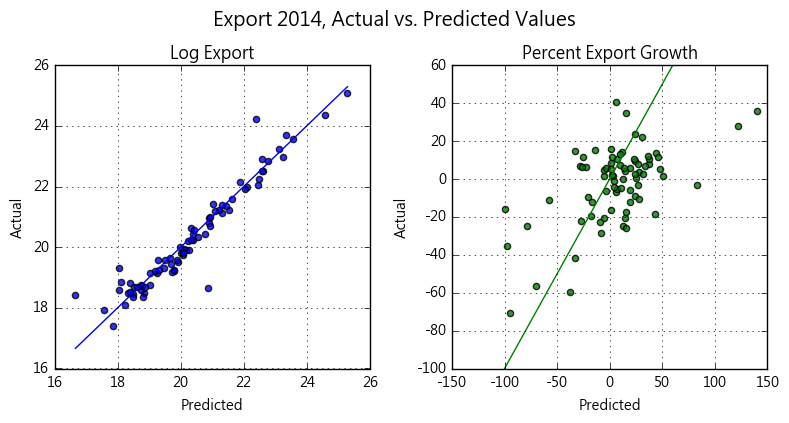

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.suptitle('Export {}, Actual vs. Predicted Values'.format(test_year), y=1.05, size=14)

rs.plot(ax=axes[0], x='ex_pred', y='ex_actual', kind='scatter', alpha=0.8, title='Log Export')
# for i, c in enumerate(rs['country']):
#     axes[0].annotate(c, (rs['ex_pred'][i], rs['ex_actual'][i]), size=6, alpha=0.2)
ex_min, ex_max = rs['ex_pred'].min(), rs['ex_pred'].max()
axes[0].plot([ex_min, ex_max], [ex_min, ex_max], 'b')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].grid()

rs.plot(ax=axes[1], x='ex_growth_pred', y='ex_growth_actual', kind='scatter', alpha=0.8, c='g',
        title='Percent Export Growth')
# for i, c in enumerate(rs['country']):
#     axes[1].annotate(c, (rs['ex_growth_pred'][i], rs['ex_growth_actual'][i]), size=1, alpha=0.2)
axes[1].plot([-100, 150], [-100, 150], 'g')
axes[1].axis([-150, 150, -100, 60])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].grid()

plt.tight_layout()
plt.show()

#### Learning Curve: Are More Data Likely to Help?

### 1.2 Training with More Recent Data

- Training: 1997-2015 (19 years)
- Test: 2016

#### Evaluation

#### Error Analysis

#### Prediction

## Model 2: SVR Using Demeaned Variables

## Model 3: ARIMA

#### Scrape Monthly Export Data

In [1]:
%% time

import datetime
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from io import StringIO
import pandas as pd
from functools import reduce

def get_mof_ts():
    
    current_year = datetime.datetime.now().year - 1911
    url = 'https://portal.sw.nat.gov.tw/APGA/GA06_csv'
    # Suppress InsecureRequestWarning
    requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    def get_data(year):
        payload = {'searchInfo.StartYear': str(year),
                   'searchInfo.EndYear': '',
                   'searchInfo.StartMonth': '1',
                   'searchInfo.EndMonth': '12',
                   'searchInfo.TypeTime': '0',
                   'searchInfo.Type': 'MoneyUSD',
                   'searchInfo.CountryName': '全部國家合計,千里達,土耳其,土庫曼,大溪地,不丹,中非,中國大陸,丹麥,厄瓜多,厄利垂亞,巴布亞紐幾內亞,巴西,巴貝多,巴拉圭,巴林,巴哈馬,巴拿馬,巴勒斯坦,巴基斯坦,日本,比利時,牙買加,以色列,加拿大,加彭,北韓,卡達,古巴,史瓦濟蘭,尼日,尼加拉瓜,尼泊爾,布吉納法索,未列名法屬中美洲領域,未列名美屬中美洲領域,未列名美屬太平洋領域,未列名英屬中美洲領域,瓜地馬拉,甘比亞,白俄羅斯,立陶宛,伊拉克,伊朗,冰島,列支敦斯登,匈牙利,印尼,印度,吉布地,吉里巴斯,吉爾吉斯,吐瓦魯,多米尼克,多明尼加,多哥,安地卡,安圭拉,安哥拉,安道爾,衣索比亞,西班牙,西撒哈拉,克羅埃西亞,利比亞,宏都拉斯,希臘,沙烏地阿拉伯,汶萊,貝里斯,貝南,赤道幾內亞,辛巴威,亞美尼亞,亞塞拜然,其他大洋洲國家,其他中東及近東國家,其他中美洲國家,其他北美洲國家,其他亞洲國家,其他非洲國家,其他南美洲國家,其他國家,其他歐洲國家,坦尚尼亞,奈及利亞,委內瑞拉,孟加拉,尚比亞,帛琉,拉脫維亞,東加,波士尼亞赫塞哥維納,波札那,波多黎各,波蘭,法國,法屬圭亞那,肯亞,芬蘭,阿拉伯聯合大公國,阿根廷,阿曼,阿富汗,阿爾及利亞,阿爾巴尼亞,保加利亞,俄羅斯,南非,南韓,南蘇丹,哈薩克,柬埔寨,查德,玻利維亞,科威特,突尼西亞,約旦,美國,美屬薩摩亞,茅利塔尼亞伊斯蘭共和國,英國,迦納,香港,剛果,剛果民主共和國,哥倫比亞,哥斯大黎加,埃及,挪威,格陵蘭,格瑞那達,泰國,海地,烏干達,烏克蘭,烏拉圭,烏茲別克,琉球,秘魯,索馬利亞,索羅門群島,紐西蘭,納米比亞,納維斯,馬利,馬來西亞,馬其頓,馬拉威,馬約特,馬紹爾群島共和國,馬達加斯加,馬爾他,馬爾地夫,捷克,捷克,教廷,敘利亞,莫三比克,荷蘭,喀麥隆,喬治亞,幾內亞,幾內亞比索,斐濟,斯里蘭卡,斯洛伐克,斯洛維尼亞,智利,菲律賓,象牙海岸,越南,塞內加爾,塞席爾,塞爾維亞,塞爾維亞與蒙特內哥羅,塔吉克,奧地利,愛沙尼亞,愛爾蘭,新加坡,新克里多尼亞,獅子山,瑞士,瑞典,萬那杜,義大利,聖文森,聖多美普林西比,聖克里斯多福,聖馬利諾,聖露西亞,葉門,葛摩聯盟,葡萄牙,維德角,蒙古,蒙特內哥羅共和國,蒙瑟拉特,蒲隆地,蓋亞那,寮國,德國,摩洛哥,摩納哥,摩爾多瓦,模里西斯,緬甸,黎巴嫩,墨西哥,澳大利亞,澳門,盧安達,盧森堡,諾魯,賴比瑞亞,賴索托,賽普勒斯,薩伊,薩爾瓦多,薩摩亞,羅馬尼亞,關島,蘇丹,蘇利南,蘇聯',
                   'noData': 'false'}
        resp = requests.post(url, data=payload, verify=False)
        skiprows = None
        # For data after 2016, need to remove header "註：105年起按一般貿易制度編製。"
        if year >= 105:
            skiprows = 1
        # Get data in bytes, decode, and convert to dataframe
        df = pd.read_csv(StringIO(resp.content.decode(encoding='big5')), skiprows=skiprows)[
            ['日期', '國家', '出口總值']]
        return df

    df_map = map(lambda x: get_data(x), range(92, current_year + 1))
    df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), df_map)

    # Parse into year and month
    df[['year', 'month']] = df['日期'].str.extract('(\d+)年(\d+)月', expand=False)
    # Create DatetimeIndex
    df.index = pd.to_datetime((df['year'].astype(int) + 1911).astype(str) + '-' + df['month'],
                              format='%Y-%m')
    df.index.name = 'date'
    # Keep only useful columns
    df = df[['國家', '出口總值']]
    df.columns = ['country', 'export']
    # Make wide dataframe
    df = pd.pivot_table(df, index=df.index, columns='country', values='export', fill_value=0)

    # Sum of newsouth eighteen and ten
    eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡',
                '柬埔寨', '汶萊', '泰國', '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
    ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
    df['十八國'] = df.loc[:, eighteen].sum(axis=1)
    df['十國'] = df.loc[:, ten].sum(axis=1)

    return df

ts = get_mof_ts()

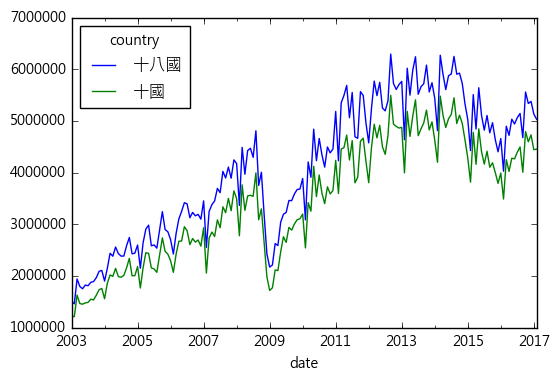

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
ts[['十八國', '十國']].plot()
plt.show()

## Model 4: Neural Network

## Model 5: Randomized Feature Selection

## Ensemble 1: Averaging Ensemble

## Ensemble 2: Standard Linear Regression Stacking

$$b(x) = \sum_i w_i g_i(x),\forall x$$

## Ensemble 3: Feature-Weighted Linear Stacking (FWLS)

$$b(x) = \sum_{i, j}\ v_{ij}\ f_j(x)\ g_i(x), \forall x$$

where $f_j$ are meta-feature functions.